## Optimal Portfolio Weights III: Leverage

In [3]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                                # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

### Get data

Get ETF prices and returns (GLD: Gold ETF, TLT: 20+ year treasuries:

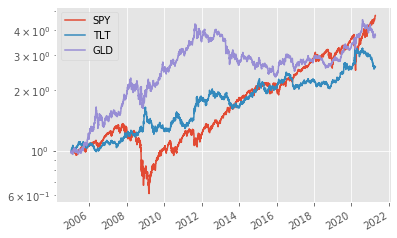

In [4]:
# start in 2005 since GLD not available earlier
PRICE = tiingo.get_dataframe(['SPY','GLD','TLT'], '2005-1-1', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)

RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1']) / 100
RATES.columns = ['FedFunds','Treasury_1']

RET = PRICE.pct_change()
RET = RET.join(RATES.FedFunds.rename('MarginLoan'), how='outer')
RET['MarginLoan'] = RET.MarginLoan.ffill()/252 + 0.01/252           # Assume margin rate = fed funds rate + 100 bsp
RET = RET.dropna(subset=['SPY'])

RET[['SPY','TLT','GLD']].add(1).cumprod().plot(logy=True)

### Backtesting the minimum volatility strategy

Basic backtest loop:

In [7]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)




def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 
    
    portfolio_value = pd.Series(1,                      index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=RET.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=RET.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        start_weights = select_weights(start_date)
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions  * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Run the backtest:

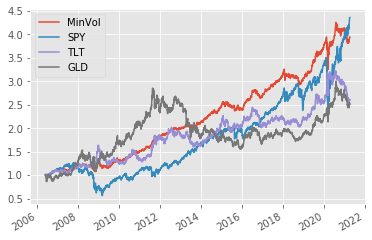

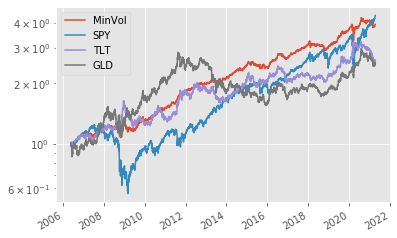

In [14]:
def select_weights(date):
        cov     = RET[['SPY','TLT','GLD']][:date][-100:].cov() * 252
        cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
        w = cov_inv.sum() /  cov_inv.sum().sum()  
        return w
    
    
min_vol, weights, trades = run_backtest('month', '2006-01-01')

min_vol = min_vol.rename('MinVol')

t = pd.DataFrame(min_vol).join(RET[['SPY','TLT','GLD']])

t[100:].add(1).cumprod().plot()
t[100:].add(1).cumprod().plot(logy=True)

Compare statistics for this table:

In [15]:
annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)
r_annual_Tbill = RATES.Treasury_1.resample('A').first()

x = pd.DataFrame()                        
x['Average_returns']   = annual_returns.mean()
x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
x['Volatility']        = t[:'2020'].std() * 252**0.5    
x['Sharpe_ratio']      = x.Risk_premium / x.Volatility
x

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
MinVol,0.100066,0.097463,0.085513,0.082999,1.030285
SPY,0.112827,0.097954,0.098274,0.200886,0.489203
TLT,0.081284,0.070236,0.066731,0.144719,0.461107
GLD,0.098515,0.086228,0.083962,0.185648,0.452264


Average return review:

In [22]:
r1 =  0.1
r2 = -0.1

value_1_dollar_invested = (1+r1)*(1+r2)
compound_ret            = value_1_dollar_invested - 1
average_ret             = (r1+r2)/2
geometric_average_ret   = value_1_dollar_invested**(1/2)-1

print('value_1_dollar_invested:', round(value_1_dollar_invested, 5))
print('compound_ret:',            round(compound_ret,            5))
print('average_ret:',             round(average_ret,             5))
print('geometric_average_ret:',   round(geometric_average_ret,   5))

value_1_dollar_invested: 0.99
compound_ret: -0.01
average_ret: 0.0
geometric_average_ret: -0.00501


Let's put the calculation of the return statistics and the plots into a function:

In [23]:
def compare_performance(t):
    t.add(1).cumprod().plot()
    t.add(1).cumprod().plot(logy=True)

    annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)
    r_annual_Tbill = RATES.Treasury_1.resample('A').first()

    x = pd.DataFrame()                        
    x['Average_returns']   = annual_returns.mean()
    x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
    x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
    x['Volatility']        = t[:'2020'].std() * 252**0.5    
    x['Sharpe_ratio']      = x.Risk_premium / x.Volatility

    return x

### Backtest with leverage

Example weights with leverage:

In [25]:
w = pd.Series({'SPY':0.6,'TLT':0.4})

w.multiply(1.5)

SPY    0.9
TLT    0.6
dtype: float64

Add the margin loan:

In [27]:
pd.Series({'MarginLoan':-0.5})

MarginLoan   -0.5
dtype: float64

In [29]:
w.multiply(1.5).append(pd.Series({'MarginLoan':-0.5}))

SPY           0.9
TLT           0.6
MarginLoan   -0.5
dtype: float64

Put the leverage into the "select_weights" function:

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
MinVol_levered,0.139858,0.133697,0.125304,0.124852,1.003620
MinVol,0.100066,0.097463,0.085513,0.082999,1.030285
SPY,0.112827,0.097954,0.098274,0.200886,0.489203
TLT,0.081284,0.070236,0.066731,0.144719,0.461107
GLD,0.098515,0.086228,0.083962,0.185648,0.452264


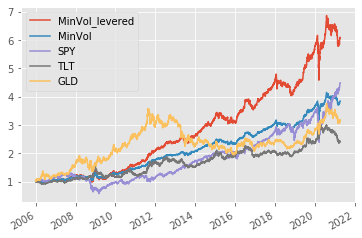

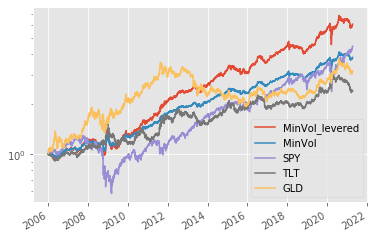

In [30]:
def select_weights(date):
    cov     = RET[['SPY','TLT','GLD']][:date][-100:].cov() * 252
    cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)

    w = cov_inv.sum() /  cov_inv.sum().sum() 
    w = w.multiply(1.5).append(pd.Series({'MarginLoan':-0.5}))
    
    return w
    
    
min_vol_levered, weights, trades = run_backtest('month','2006-1-1')

min_vol_levered = min_vol_levered.rename('MinVol_levered')

t = pd.DataFrame(min_vol_levered).join(min_vol).join(RET[['SPY','TLT','GLD']])

compare_performance(t)

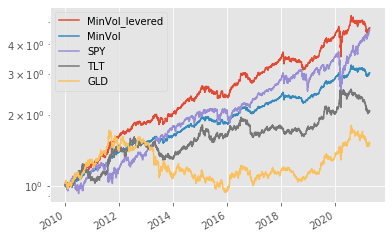

In [33]:
t['2010':].add(1).cumprod().plot(logy=True)

Portfolio weights:

In [31]:
weights

,SPY,GLD,TLT,MarginLoan
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,0.554863,0.157713,0.785068,-0.497644
2006-01-05,0.557182,0.155422,0.786911,-0.499514
2006-01-06,0.557817,0.158384,0.779860,-0.496061
2006-01-09,0.556781,0.160268,0.776926,-0.493975
...,...,...,...,...
2021-04-06,0.595837,0.234826,0.653803,-0.484466
2021-04-07,0.599251,0.235234,0.652214,-0.486699
2021-04-08,0.595699,0.235237,0.650613,-0.481549
2021-04-09,0.599922,0.233422,0.648139,-0.481483


Plot the weights:

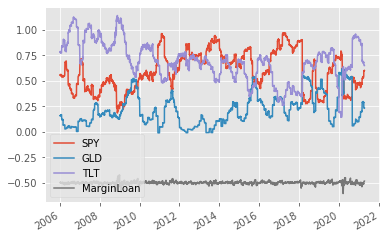

In [34]:
weights.plot()

Calculate leverage ratio:

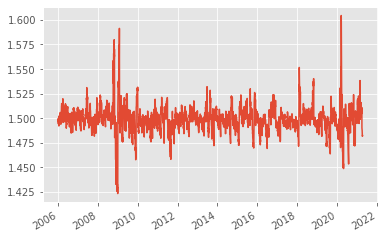

In [37]:
weights.MarginLoan.abs().add(1).plot()

Compare drawdowns:

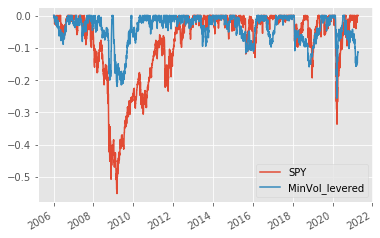

In [35]:
hwm = t.add(1).cumprod().cummax()                # high water mark

drawdown = t.add(1).cumprod()/hwm - 1.0          # % portfolio loss relative to most recent peak (high water mark)

drawdown[['SPY','MinVol_levered']].plot()